In [1]:
import os
import tensorflow as tf
import numpy as np

import constants
from datasets import DependencyDataset
from network import DistanceProbe, DepthProbe

import matplotlib.pyplot as plt

In [2]:
def orthogonality_check(matrix):
    assert len(matrix.shape) == 2, "Only 2D matrices suported"
    fro_norm = np.linalg.norm(matrix @ matrix.transpose() -  np.eye(matrix.shape[0]), ord='fro')
    if matrix.shape[0] != matrix.shape[1]:
        fro_norm += np.linalg.norm(matrix.transpose() @ matrix - np.eye(matrix.shape[1]), ord='fro')
        fro_norm /= 2.
    return fro_norm


def matrix_cos_distance(matrixA, matrixB):
    EPSILON = 1e-4
    assert np.linalg.norm(matrixA) > EPSILON
    assert np.linalg.norm(matrixB) > EPSILON
    return np.linalg.norm(matrixA - matrixB, ord='fro') / (np.linalg.norm(matrixA, ord='fro') * np.linalg.norm(matrixB, ord='fro'))

def matrix_max_distance(matrixA, matrixB):
    return np.max(np.abs(matrixA - matrixB))

def matrix_smpl_distance(matrixA, matrixB):
    NUM_SMPL = 100
    sample = np.random.randn(NUM_SMPL, matrixA.shape[0])
    sample = sample / np.linalg.norm(sample, axis=-1, keepdims=True)
    A_smpl = sample @ matrixA
    B_smpl = sample @ matrixB
    return np.mean(np.linalg.norm(A_smpl - B_smpl, axis=-1))
    

# DEPTH MATRICES

In [63]:
model_dim = 768
probe_rank = 768

languages = ['en', 'fr', 'de']
out_dir = 'experiments/train_en_de_fr/task_depth-layer_6-trainl_en_de_fr/'


DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_depth-layer_6-trainl_en_de_fr/params/ckpt-12'

In [64]:
en_map_depth = ckpt.en.numpy()
fr_map_depth = ckpt.fr.numpy()
de_map_depth  = ckpt.de.numpy()
depth_probe = ckpt.depth_probe.numpy()

## Conduct SVD and compare non orthogonal part of the matrix

In [65]:
orthogonality_check(en_map_depth)

15.058353652093482

In [66]:
orthogonality_check(de_map_depth)

15.259980829491433

In [67]:
orthogonality_check(fr_map_depth)

15.843890662679716

depth probe matrix and language map matrices are not orthogonal

In [68]:
en_u, en_s, en_v =  np.linalg.svd(en_map_depth)
de_u, de_s, de_v =  np.linalg.svd(de_map_depth)
fr_u, fr_s, fr_v =  np.linalg.svd(fr_map_depth)
depth_u, depth_s, depth_v =  np.linalg.svd(depth_probe)

# en_sv = np.diag(en_s) @ en_v
# de_sv = np.diag(de_s) @ de_v
# fr_sv = np.diag(fr_s) @ fr_v

In [69]:
np.linalg.norm(en_s)

26.680162

In [70]:
np.mean(en_s)

0.908904

In [71]:
np.linalg.norm(depth_s)

2.699213

Most of scaling is done in language specific matrix. It hinders multilanguage aspect of the probe.
On the other hand depth probe is responsible for downscaling, mean eigenvalue of lang specific matrix is close to one. I think it is mostly due to intialization.

In [72]:
np.linalg.norm(en_s - de_s)

0.7724513

In [73]:
np.linalg.norm(en_s - fr_s)

0.39260736

In [74]:
np.linalg.norm(de_s - fr_s)

0.6916721

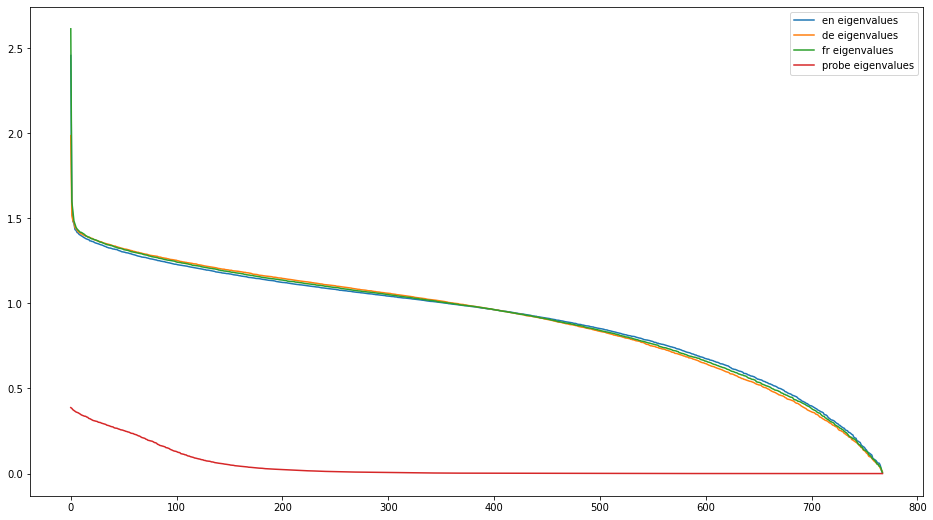

In [75]:
plt.figure(figsize=[16,9])
plt.plot(en_s, label='en eigenvalues')
plt.plot(de_s, label='de eigenvalues')
plt.plot(fr_s, label='fr eigenvalues')
plt.plot(depth_s, label='probe eigenvalues')
#plt.ylim([0.8, 1.05])
plt.legend()
plt.show()

Takeway: Language specific matrices have similar singular values

In [107]:
np.mean(np.max(en_v @ fr_v.transpose(), axis=-1) / np.max(en_u.transpose() @ fr_u, axis=0))

1.0238862

In [108]:
np.mean(np.max(en_v @ de_v.transpose(), axis=-1) / np.max(en_u.transpose() @ de_u, axis=0))

1.0285408

In [109]:
np.mean(np.max(fr_v @ de_v.transpose(), axis=-1) / np.max(fr_u.transpose() @ de_u, axis=0))

1.0191784

?Takeway: right multiplication by U makes vector space less language dependent (where U @ S @ V = SVD(M))

# DISTANCE MATRICES

In [95]:
model_dim = 768
probe_rank = 768

languages = ['en', 'fr', 'de']
out_dir = 'experiments/train_en_de_fr/task_distance-layer_6-trainl_en_de_fr/'


DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr/task_distance-layer_6-trainl_en_de_fr/params/ckpt-15'

In [110]:
en_map_dist = ckpt.en.numpy()
fr_map_dist = ckpt.fr.numpy()
de_map_dist = ckpt.de.numpy()
distance_probe = ckpt.distance_probe.numpy()

In [111]:
en_u, en_s, en_v =  np.linalg.svd(en_map_dist)
de_u, de_s, de_v =  np.linalg.svd(de_map_dist)
fr_u, fr_s, fr_v =  np.linalg.svd(fr_map_dist)
dist_u, dist_s, dist_v =  np.linalg.svd(distance_probe)

In [112]:
orthogonality_check(en_map_dist)

18.396372620066515

In [113]:
np.linalg.norm(en_s)

27.887388

In [138]:
np.linalg.norm(dist_s)

2.6431499

In [136]:
np.linalg.norm(dist_s)

2.6431499

In [120]:
np.linalg.norm(en_s - de_s)

0.5069455

In [119]:
np.linalg.norm(en_s - fr_s)

0.21521693

In [118]:
np.linalg.norm(de_s - fr_s)

0.5700357

Observation: eigenvalues of maps across languages are closer in distance probing than depth probing

In [121]:
np.mean(np.max(en_v @ fr_v.transpose(), axis=-1) / np.max(en_u.transpose() @ fr_u, axis=0))

1.0151405

In [122]:
np.mean(np.max(en_v @ de_v.transpose(), axis=-1) / np.max(en_u.transpose() @ de_u, axis=0))

1.0247933

In [123]:
np.mean(np.max(fr_v @ de_v.transpose(), axis=-1) / np.max(fr_u.transpose() @ de_u, axis=0))

1.017285

# Comprison of Language specific matrices in Depth and Distance probes

In [124]:
matrix_cos_distance(en_map_depth, en_map_dist)

0.012554613

In [125]:
matrix_cos_distance(fr_map_depth, fr_map_dist)

0.012928756

In [126]:
matrix_cos_distance(de_map_depth, de_map_dist)

0.012441403

In [127]:
matrix_cos_distance(distance_probe, depth_probe)

0.52868587

In [141]:
np.linalg.norm(en_map_depth - en_map_dist, ord='fro')

9.3411

In [140]:
np.linalg.norm(distance_probe - depth_probe, ord='fro')

3.7718587

In [130]:
matrix_smpl_distance(en_map_depth, en_map_dist)

0.3365877558739269

In [134]:
matrix_max_distance(en_map_depth, en_map_dist)

0.096884206

In [135]:
matrix_max_distance(distance_probe, depth_probe)

0.15160161

# DEPTH MATRICES with ORTHOGONALITY CONSTRAINT

In [6]:
model_dim = 768
probe_rank = 768

languages = ['en', 'fr', 'de']
out_dir = 'experiments/train_en_de_fr_ortho/task_depth-layer_6-trainl_en_de_fr_ortho_1._dso/'


DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr_ortho/task_depth-layer_6-trainl_en_de_fr_ortho_1._dso/params/ckpt-12'

In [7]:
en_map_depth = ckpt.en.numpy()
fr_map_depth = ckpt.fr.numpy()
de_map_depth  = ckpt.de.numpy()
depth_probe = ckpt.depth_probe.numpy()

In [8]:
orthogonality_check(en_map_depth)

0.7645905480652638

In [9]:
orthogonality_check(fr_map_depth)

0.6718994420994511

In [10]:
orthogonality_check(de_map_depth)

0.9906213459231713

In [11]:
orthogonality_check(depth_probe)

27.55194293886825

In [57]:
en_u, en_s, en_v =  np.linalg.svd(en_map_depth)
de_u, de_s, de_v =  np.linalg.svd(de_map_depth)
fr_u, fr_s, fr_v =  np.linalg.svd(fr_map_depth)
depth_u, depth_s, depth_v =  np.linalg.svd(depth_probe)

In [10]:
np.linalg.norm(en_s - de_s)

0.39182183

In [11]:
np.linalg.norm(fr_s - de_s)

0.47894534

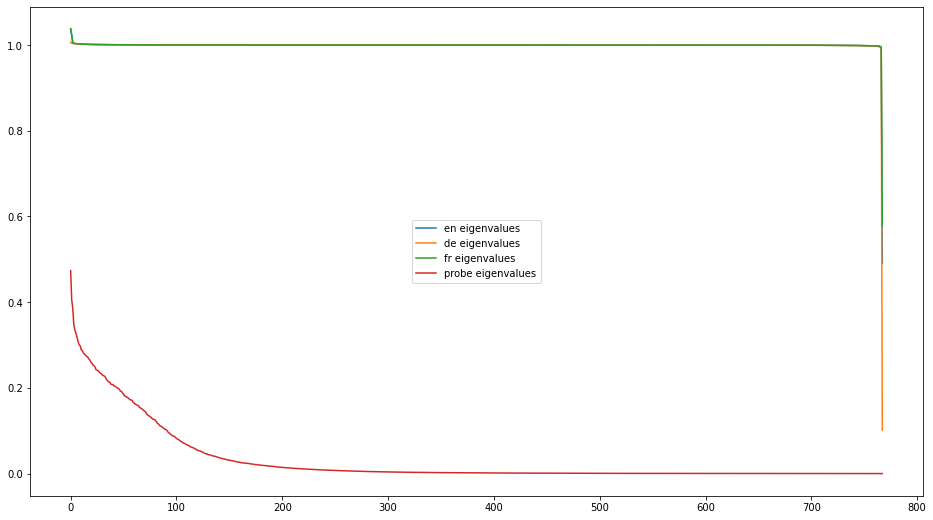

In [62]:
plt.figure(figsize=[16,9])
plt.plot(en_s, label='en eigenvalues')
plt.plot(de_s, label='de eigenvalues')
plt.plot(fr_s, label='fr eigenvalues')
plt.plot(depth_s, label='probe eigenvalues')
#plt.ylim([0.8, 1.05])
plt.legend()
plt.show()

In [59]:
np.mean(np.max(en_v @ fr_v.transpose(), axis=-1) / np.max(en_u.transpose() @ fr_u, axis=0))

1.1277322

In [17]:
de_s

array([1.0066708 , 1.0039544 , 1.003847  , 1.0034826 , 1.0029308 ,
       1.0027343 , 1.0025635 , 1.0023947 , 1.0022851 , 1.0021883 ,
       1.0020903 , 1.0020072 , 1.0019116 , 1.0018849 , 1.0017798 ,
       1.0017632 , 1.001684  , 1.0015615 , 1.0015225 , 1.0014782 ,
       1.0014042 , 1.001388  , 1.001369  , 1.001313  , 1.0012624 ,
       1.0012033 , 1.0011976 , 1.0011812 , 1.001149  , 1.0011042 ,
       1.0010848 , 1.0010588 , 1.0010414 , 1.0010208 , 1.0010015 ,
       1.0009574 , 1.0009307 , 1.0009037 , 1.00089   , 1.0008813 ,
       1.0008382 , 1.0008117 , 1.0008018 , 1.0007958 , 1.0007665 ,
       1.0007479 , 1.0007323 , 1.000711  , 1.0006855 , 1.0006747 ,
       1.0006609 , 1.0006443 , 1.0006148 , 1.0006002 , 1.0005823 ,
       1.0005679 , 1.0005579 , 1.0005282 , 1.0005099 , 1.0005066 ,
       1.0004894 , 1.0004803 , 1.0004673 , 1.0004525 , 1.0004368 ,
       1.0004282 , 1.0004176 , 1.0004134 , 1.0003892 , 1.0003856 ,
       1.0003777 , 1.0003656 , 1.0003603 , 1.0003439 , 1.00033

In [18]:
fr_s

array([1.037841  , 1.0233574 , 1.0048531 , 1.0039718 , 1.0036577 ,
       1.0031725 , 1.0027844 , 1.0025699 , 1.002505  , 1.0022988 ,
       1.0022601 , 1.002167  , 1.0019654 , 1.0017883 , 1.0017594 ,
       1.0016911 , 1.0015578 , 1.0014827 , 1.0014424 , 1.001397  ,
       1.001319  , 1.0012664 , 1.0012002 , 1.0011814 , 1.0011474 ,
       1.0010954 , 1.0010693 , 1.001018  , 1.0010087 , 1.0009555 ,
       1.000924  , 1.0008924 , 1.0008684 , 1.000857  , 1.0008134 ,
       1.0008003 , 1.0007737 , 1.0007669 , 1.0007485 , 1.0007244 ,
       1.0007176 , 1.0006851 , 1.0006675 , 1.0006427 , 1.0006303 ,
       1.0006092 , 1.0005864 , 1.0005778 , 1.0005608 , 1.0005568 ,
       1.00054   , 1.0005205 , 1.0005168 , 1.0005013 , 1.0004926 ,
       1.0004631 , 1.0004618 , 1.0004463 , 1.0004344 , 1.0004231 ,
       1.0004201 , 1.0004002 , 1.0003929 , 1.0003892 , 1.0003748 ,
       1.0003662 , 1.0003611 , 1.0003407 , 1.0003309 , 1.0003247 ,
       1.0003153 , 1.0003101 , 1.0002975 , 1.0002905 , 1.00028

# DISTANCE MATRICES with ORTHOGONALITY CONSTRAINT

In [13]:
model_dim = 768
probe_rank = 768

languages = ['en', 'fr', 'de']
out_dir = 'experiments/train_en_de_fr_ortho/task_distance-layer_6-trainl_en_de_fr_ortho_1._dso/'


DistanceProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='distance_probe', dtype=tf.float32)

DepthProbe = tf.Variable(tf.random_uniform_initializer(minval=-0.05, maxval=0.05, seed=42)
                             ((probe_rank, model_dim)),
                             trainable=True, name='depth_probe', dtype=tf.float32)

optimizer=tf.optimizers.Adam()

LanguageMaps = {lang: tf.Variable(tf.initializers.Identity(gain=1.0)((model_dim, model_dim)),
                                               trainable=False, name='{}_map'.format(lang))
                             for lang in languages}
ckpt = tf.train.Checkpoint(optimizer=optimizer, depth_probe=DepthProbe, distance_probe=DistanceProbe, **LanguageMaps)

checkpoint_manger = tf.train.CheckpointManager(ckpt, os.path.join(out_dir, 'params'), max_to_keep=1)

checkpoint_manger.restore_or_initialize()

'experiments/train_en_de_fr_ortho/task_distance-layer_6-trainl_en_de_fr_ortho_1._dso/params/ckpt-20'

In [14]:
en_map_distance = ckpt.en.numpy()
fr_map_distance = ckpt.fr.numpy()
de_map_distance  = ckpt.de.numpy()
distance_probe = ckpt.distance_probe.numpy()

In [15]:
orthogonality_check(en_map_distance)

1.9462458136817424e-05

In [16]:
orthogonality_check(fr_map_distance)

1.9471124160947498e-05

In [30]:
orthogonality_check(distance_probe)

27.48387829288227

In [31]:
en_u, en_s, en_v =  np.linalg.svd(en_map_distance)
de_u, de_s, de_v =  np.linalg.svd(de_map_distance)
fr_u, fr_s, fr_v =  np.linalg.svd(fr_map_distance)
distance_u, distance_s, distance_v =  np.linalg.svd(distance_probe)

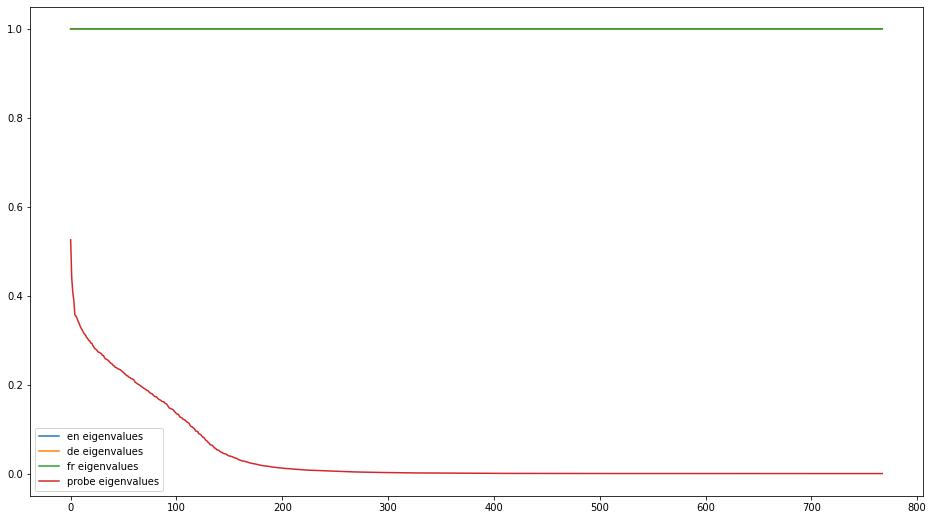

In [33]:
plt.figure(figsize=[16,9])
plt.plot(en_s, label='en eigenvalues')
plt.plot(de_s, label='de eigenvalues')
plt.plot(fr_s, label='fr eigenvalues')
plt.plot(distance_s, label='probe eigenvalues')
#plt.ylim([0.8, 1.05])
plt.legend()
plt.show()

In [37]:
matrix_smpl_distance(en_map_depth, en_map_distance)

0.9595089391764223

In [38]:
matrix_smpl_distance(en_map_depth, fr_map_depth)

0.8214079999495911

In [39]:
matrix_smpl_distance(fr_map_distance, fr_map_depth)

0.9605946863860961

In [40]:
matrix_smpl_distance(en_map_distance, fr_map_distance)

0.9512517506629828

In [41]:
matrix_smpl_distance(en_map_depth, de_map_distance)

0.9819832071493951

In [35]:
en_map_distance

array([[ 0.7521539 ,  0.01371565,  0.02153927, ..., -0.01763755,
         0.02950492,  0.06344136],
       [-0.03690137,  0.69589615, -0.02401245, ..., -0.01475647,
        -0.01752466, -0.01342426],
       [-0.01676211, -0.00113208,  0.738546  , ..., -0.01658557,
         0.00539953,  0.00673981],
       ...,
       [ 0.01096843, -0.02123662, -0.02205694, ...,  0.66213965,
         0.00347736,  0.03425073],
       [ 0.01229717,  0.01830409, -0.00958871, ...,  0.00933759,
         0.6990686 , -0.01948741],
       [-0.04965568, -0.02408411, -0.02114687, ...,  0.00368433,
        -0.00885504,  0.58397526]], dtype=float32)

In [36]:
fr_map_distance

array([[ 7.0838064e-01, -3.3767927e-02, -2.0554403e-02, ...,
        -2.2334931e-03,  1.5735434e-02,  1.5522198e-02],
       [ 1.1787200e-02,  7.0018190e-01,  1.4714720e-02, ...,
        -3.8528804e-02, -1.5454463e-02, -1.6481283e-03],
       [ 4.6777703e-02, -2.6050841e-02,  7.4486256e-01, ...,
        -1.0209412e-02,  4.9033392e-02,  1.7696686e-02],
       ...,
       [ 1.7284077e-02,  1.1983007e-02, -4.9201248e-04, ...,
         6.6485858e-01, -1.9598693e-02, -2.9464060e-02],
       [ 9.0703247e-03,  2.0430395e-03, -4.0280435e-02, ...,
         1.2469566e-02,  7.0943373e-01,  2.0360809e-02],
       [ 2.8636785e-02,  8.0670137e-03, -7.7706384e-03, ...,
        -2.9801797e-02, -3.5127942e-02,  5.8171767e-01]], dtype=float32)